In [1]:
from src.datasets.registry import get_dataset
from src.datasets.common import BaseDataset
from pathlib import Path
import json
from src.utils import download_and_extract_dataset

In [2]:
DATASET_NAMES = ["CHAOS", "MMWHS"]
DOMAINS = ["CT", "MR"]
DATA_PATH = "data/"
CHECKPOINT_PATH = "checkpoints/"
USE_3D = False
TRAINING_EPOCHS = {
    ("CHAOS", "CT"): 1,
}
BATCH_SIZE = 64
SPATIAL_SIZE = 64
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# Set True to enable debug prints/timers/visualizations)
DEBUG = True

In [3]:
CACHE_MAX_ITEMS = 32  # set the in-memory file cache size per dataset (images and segs)
ENABLE_CACHE = True    # set to False to disable caching entirely

In [4]:
CHECKPOINT_PATH = Path(CHECKPOINT_PATH)
DATA_PATH = Path(DATA_PATH)
CHECKPOINT_PATH.mkdir(parents=True, exist_ok=True)

if USE_3D:
    encoder_type = "swin_unetr"
else:
    encoder_type = "clipseg"

In [5]:
import torch
from monai import transforms


# Normalization stats (mean, std) per dataset/domain
NORM_STATS = {
    ("MMWHS", "MR"):  (186.5875, 258.5917),
    ("MMWHS", "CT"):  (-745.0086, 1042.7251),
    ("CHAOS",  "MR"): (90.8292, 168.8922),
    ("CHAOS",  "CT"): (-478.1732, 476.7163),
}

# Optimized preprocessing: resize early

def get_preprocessing(dataset_name: str, domain: str, is_training=True):
    decode_func = get_decode_func(dataset_name, domain)
    mean_std = NORM_STATS.get((dataset_name, domain))
    mean, std = (mean_std if mean_std is not None else (None, None))

    # Image-specific transforms
    if USE_3D:
        image_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]
    else:
        image_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]

    # Resize early to reduce compute
    image_transforms.append(
        transforms.Resize(
            spatial_size=SPATIAL_SIZE,
            size_mode="longest",
            mode="area",
            anti_aliasing=True,
        )
    )

    # Convert to tensor and ensure float32 for stable CPU ops
    image_transforms.extend([
        transforms.ToTensor(),
        transforms.EnsureType(dtype=torch.float32),
    ])

    # Augmentations (training only) — run in float32 on CPU
    if is_training:
        image_transforms.extend(
            [
                transforms.RandGaussianNoise(prob=0.15, std=0.05),
                transforms.RandAdjustContrast(prob=0.15, gamma=(0.95, 1.05)),
            ]
        )

    # Normalize (still in float32)
    if mean is not None and std is not None:
        image_transforms.append(
            transforms.NormalizeIntensity(
                subtrahend=float(mean),
                divisor=float(std),
                channel_wise=False,
            )
        )

    # Repeat to 3 channels only at the end (2D only)
    if not USE_3D:
        image_transforms.append(transforms.RepeatChannel(repeats=3))

    image_transform = transforms.Compose(image_transforms)

    # Segmentation transforms
    if not USE_3D:
        seg_transforms = [
            transforms.Lambda(lambda x: x.squeeze(-1)),
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
        ]
    else:
        seg_transforms = [
            transforms.EnsureChannelFirst(channel_dim="no_channel"),
            transforms.Orientation(axcodes="RAS"),
        ]

    seg_transforms.extend(
        [
            transforms.ToTensor(),
            transforms.EnsureType(dtype=torch.float32),
            transforms.Lambda(lambda x: decode_func(x)),  # decode after tensor conversion
            transforms.Resize(
                spatial_size=SPATIAL_SIZE, size_mode="longest", mode="nearest"
            ),
            transforms.EnsureType(dtype=torch.float32),
        ]
    )

    seg_transform = transforms.Compose(seg_transforms)
    return image_transform, seg_transform


def get_decode_func(dataset_name, domain):
    from src.datasets.mmwhs import mmwhs_labels

    decode = None
    if dataset_name == "CHAOS":
        if domain in ["MR", "MRI"]:
            def decode(labels):
                # Convert intensity values to class indices (keep as float32)
                return labels // 63
        elif domain == "CT":
            def decode(labels):
                return torch.where(labels > 0, 1.0, 0.0)
    elif dataset_name == "MMWHS":
        def decode(labels):
            decoded_labels = torch.zeros_like(labels, dtype=torch.float32)
            for i, label_val in enumerate(mmwhs_labels.keys()):
                decoded_labels[labels == label_val] = i
            return decoded_labels

    if decode is None:
        def decode(labels):
            return labels

    return decode

In [6]:
def print_grad_status(model):
    trainable = []
    frozen = []
    for name, p in model.named_parameters():
        if p.requires_grad:
            trainable.append(name)
        else:
            frozen.append(name)
    print(f"\n=== Parameters requiring grad: {len(trainable)} ===")
    # for n in trainable:
        # print(f"  + {n}")
    print(f"\n=== Parameters frozen (no grad): {len(frozen)}===")
    # for n in frozen:
    #     print(f"  - {n}")

    return trainable, frozen

In [7]:
def flip_grad_status(model):
    for p in model.parameters():
        p.requires_grad_(not p.requires_grad)

In [8]:
# Helpers to snapshot parameters and report unchanged ones after finetuning
import torch

def snapshot_parameters(model):
    """Return a CPU snapshot of all parameter tensors by name."""
    return {name: p.detach().clone().cpu() for name, p in model.named_parameters()}


def print_unchanged_parameters(model, snapshot, only_requires_grad: bool = True):
    """Print all parameter names whose values are identical to the snapshot.

    Args:
        model: The model to compare.
        snapshot: Dict[name -> Tensor] with the pre-finetune parameter values.
        only_requires_grad: If True, only consider parameters with requires_grad=True.
    """
    unchanged = []
    considered = 0
    for name, p in model.named_parameters():
        if only_requires_grad and not p.requires_grad:
            continue
        prev = snapshot.get(name)
        if prev is None:
            continue
        curr = p.detach().cpu()
        considered += 1
        if torch.equal(curr, prev):
            unchanged.append(name)

    print("\n=== Parameters unchanged after finetuning ===")
    for n in unchanged:
        print(f"  - {n}")
    print(f"Total unchanged: {len(unchanged)} of {considered} considered")


Finetuning on CHAOS dataset in CT domain with 2d images 
Found explicit background class in input. Treating it separately.
Non-background classes: ['Liver']
🔄 Loading CLIPSeg weights...
Frozen 150 CLIP text-encoder params (kept visual+head trainable).

=== Parameters requiring grad: 206 ===

=== Parameters frozen (no grad): 150===
🚀 Starting training for 1 epochs
   Device: cpu
   Learning Rate: 0.001
   Weight Decay: 1e-05
   Trainable params: 206 of 356
   Params: total=150,796,962, trainable=87,368,865
   Batches: train=31, val=7
   Tracking params:
     - encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight
     - encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias
     - encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight

📖 Epoch 1/1
   LR(s): 1.000000e-03
🔄 Loading CLIPSeg weights...
Frozen 150 CLIP text-encoder params (kept visual+head trainable).

=== Parameters requiring grad: 206 ===

=== Parameter

Training:   3%|▎         | 1/31 [00:04<02:24,  4.82s/it, Loss=1.1545]

[timer] batch 0: 2.248s


Training:   6%|▋         | 2/31 [00:07<01:49,  3.78s/it, Loss=1.1732]

[timer] batch 1: 2.396s


Training:  10%|▉         | 3/31 [00:10<01:29,  3.19s/it, Loss=1.1485]

[timer] batch 2: 1.732s


Training:  13%|█▎        | 4/31 [00:13<01:29,  3.31s/it, Loss=1.1178]

[timer] batch 3: 2.537s


Training:  16%|█▌        | 5/31 [00:16<01:23,  3.19s/it, Loss=1.0656]

[timer] batch 4: 1.883s


Training:  19%|█▉        | 6/31 [00:20<01:27,  3.49s/it, Loss=1.0344]

[timer] batch 5: 1.944s


Training:  23%|██▎       | 7/31 [00:24<01:23,  3.48s/it, Loss=1.0032]

[timer] batch 6: 2.356s


Training:  26%|██▌       | 8/31 [00:28<01:24,  3.69s/it, Loss=0.9832]

[timer] batch 7: 2.014s


Training:  29%|██▉       | 9/31 [00:31<01:16,  3.46s/it, Loss=0.9648]

[timer] batch 8: 2.161s


Training:  32%|███▏      | 10/31 [00:36<01:24,  4.00s/it, Loss=0.9481]

[timer] batch 9: 2.566s


Training:  35%|███▌      | 11/31 [00:51<02:23,  7.18s/it, Loss=0.9252]

[timer] batch 10: 13.246s


Training:  39%|███▊      | 12/31 [01:06<03:03,  9.67s/it, Loss=0.9201]

[timer] batch 11: 4.061s


Training:  42%|████▏     | 13/31 [01:09<02:20,  7.81s/it, Loss=0.9334]

[timer] batch 12: 2.164s


Training:  45%|████▌     | 14/31 [01:13<01:50,  6.51s/it, Loss=0.9348]

[timer] batch 13: 1.741s


Training:  48%|████▊     | 15/31 [01:16<01:26,  5.42s/it, Loss=0.9278]

[timer] batch 14: 1.990s


Training:  52%|█████▏    | 16/31 [01:18<01:08,  4.57s/it, Loss=0.8814]

[timer] batch 15: 1.879s


Training:  55%|█████▍    | 17/31 [01:21<00:56,  4.06s/it, Loss=0.8565]

[timer] batch 16: 1.947s


Training:  58%|█████▊    | 18/31 [01:25<00:50,  3.90s/it, Loss=0.8149]

[timer] batch 17: 2.517s


Training:  61%|██████▏   | 19/31 [01:30<00:50,  4.24s/it, Loss=0.8194]

[timer] batch 18: 2.372s


Training:  65%|██████▍   | 20/31 [01:33<00:41,  3.77s/it, Loss=0.8195]

[timer] batch 19: 1.899s


Training:  68%|██████▊   | 21/31 [01:35<00:34,  3.43s/it, Loss=0.8352]

[timer] batch 20: 1.876s


Training:  71%|███████   | 22/31 [01:39<00:30,  3.39s/it, Loss=0.8281]

[timer] batch 21: 2.278s


Training:  74%|███████▍  | 23/31 [01:42<00:26,  3.34s/it, Loss=0.8279]

[timer] batch 22: 1.883s


Training:  77%|███████▋  | 24/31 [01:58<00:51,  7.32s/it, Loss=0.8208]

[timer] batch 23: 12.307s


Training:  81%|████████  | 25/31 [02:08<00:48,  8.07s/it, Loss=0.8183]

[timer] batch 24: 2.476s


Training:  84%|████████▍ | 26/31 [02:11<00:32,  6.47s/it, Loss=0.8106]

[timer] batch 25: 1.864s


Training:  87%|████████▋ | 27/31 [02:14<00:21,  5.36s/it, Loss=0.8039]

[timer] batch 26: 2.107s


Training:  90%|█████████ | 28/31 [02:16<00:13,  4.56s/it, Loss=0.7980]

[timer] batch 27: 1.802s


Training:  94%|█████████▎| 29/31 [02:19<00:08,  4.08s/it, Loss=0.7848]

[timer] batch 28: 1.820s


Training:  97%|█████████▋| 30/31 [02:23<00:03,  3.84s/it, Loss=0.7771]

[timer] batch 29: 1.879s


Training: 100%|██████████| 31/31 [02:26<00:00,  4.73s/it, Loss=0.7697]


[timer] batch 30: 2.092s
Epoch 1 - Train Loss: 0.9002
   Param norm deltas (after epoch):
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.weight: Δnorm=+1.373188e+00 (before=8.586586e+00, after=9.959774e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.0.attn.out_proj.bias: Δnorm=+1.146293e-02 (before=1.183554e+00, after=1.195017e+00)
     encoder.clipseg.clip_model.visual.transformer.resblocks.1.attn.out_proj.weight: Δnorm=+1.150630e+00 (before=8.633878e+00, after=9.784508e+00)
   Grad non-zero in batches: 31/31 (100.0%)
   Labels seen this epoch: [0, 1]


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

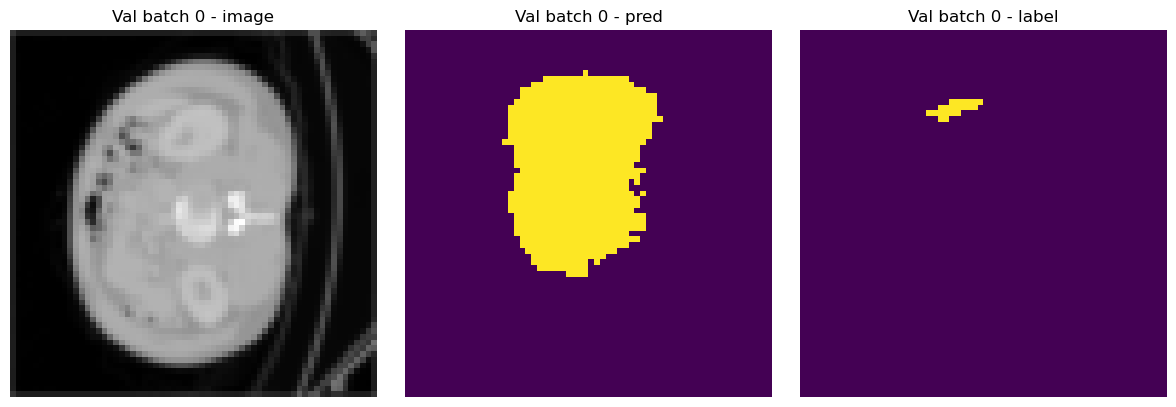

Validating:  14%|█▍        | 1/7 [00:02<00:16,  2.67s/it]



Epoch 1 - Val Loss: 0.7656
   New best Val Loss: 0.7656

✅ Training completed!

=== Parameters unchanged after finetuning ===
  - encoder.clipseg.clip_model.visual.proj
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.in_proj_weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.in_proj_bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.out_proj.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.attn.out_proj.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.ln_1.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.ln_1.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_fc.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_fc.bias
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_proj.weight
  - encoder.clipseg.clip_model.visual.transformer.resblocks.10.mlp.c_proj.bias
  - encoder.clipseg.clip_model.visual

In [9]:
# Finetuning loop

for (dataset_name, domain), epochs in TRAINING_EPOCHS.items():
    download_and_extract_dataset(dataset_name, DATA_PATH)

    image_transform, seg_transform = get_preprocessing(
        dataset_name, domain, is_training=True
    )

    print(
        f"Finetuning on {dataset_name} dataset in {domain} domain with {'3d' if USE_3D else '2d'} images "
    )
    dataset: BaseDataset = get_dataset(
        dataset_name=dataset_name,
        domain=domain,
        transform=image_transform,  # Use transform instead of preprocess
        seg_transform=seg_transform,  # Pass seg_transform too
        base_path=DATA_PATH,
        batch_size=BATCH_SIZE,
        num_workers=0,
        slice_2d=not USE_3D,
        # new cache knobs
        cache_max_items=CACHE_MAX_ITEMS,
        enable_cache=ENABLE_CACHE,
    )

    #  Ensure the dataset is loaded correctly
    if not isinstance(dataset, BaseDataset):
        raise TypeError(
            f"Expected dataset to be an instance of BaseDataset, got {type(dataset)}"
        )

    model = dataset.get_model(
        encoder_type=encoder_type,
    )

    # Unfreeze everything, then freeze CLIP text encoder (we cache text embeddings -> no grads)
    model.unfreeze()
    if encoder_type == "clipseg":
        model.freeze_text_encoder()

    # for p in model.encoder.clipseg.model.parameters():
    #     p.requires_grad_(True)


    # Print grad status before finetuning (after final freeze mask)
    print_grad_status(model)

    # Snapshot parameters before finetuning (after setting requires_grad correctly)
    before_snapshot = snapshot_parameters(model)

    history = model.finetune(
        epochs=1,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        val_max_batches=1,
        fast_val_metrics=True,
        debug=DEBUG
    )

    # Print parameters that didn't change after finetuning (only those requiring grad)
    print_unchanged_parameters(model, before_snapshot, only_requires_grad=True)